## Prepare imports

In [10]:
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt

from models.vae_mnist import VanillaVAE
from models.vae_mnist import BaseModel as BaseVAE

from models.ectencoder_mnist import BaseModel as EctEncoder

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn


from datasets.mnist import MnistDataModule
from datasets.config import MnistDataModuleConfig
from layers.ect import EctLayer, EctConfig

from directions import generate_2d_directions

DEVICE = "cuda:0"

V = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, 64, device=DEVICE)),
        torch.cos(torch.linspace(0, 2 * torch.pi, 64, device=DEVICE)),
    ]
)

config = OmegaConf.load("./configs/config_encoder_mnist.yaml")

## Load Models and Data

In [11]:
layer = EctLayer(
    EctConfig(
        num_thetas=config.layer.ect_size,
        bump_steps=config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_2d_directions(config.layer.ect_size, DEVICE),
)

dm = MnistDataModule(MnistDataModuleConfig(root="./data/mnistpointcloud"))


vae_model = VanillaVAE(in_channels=1, latent_dim=64,img_size=config.layer.ect_size)

# Load the VAE model

metrics = get_mse_metrics()

vae_litmodel = BaseVAE.load_from_checkpoint(
    "./trained_models/vae_mnist_bu.ckpt",
    model=vae_model,
    training_accuracy=metrics[0],
    test_accuracy=metrics[1],
    validation_accuracy=metrics[2],
    accuracies_fn=compute_mse_accuracies,
    loss_fn=compute_mse_loss_fn,
    learning_rate=0.01,
    layer=layer,
).to(DEVICE)


# Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/{config.encodermodel.save_name}",
    layer=layer,
    ect_size=config.layer.ect_size,
    hidden_size=config.encodermodel.hidden_size,
    num_pts=config.encodermodel.num_pts,
    num_dims=config.encodermodel.num_dims,
    learning_rate=config.encodermodel.learning_rate,
).to(DEVICE)


## Generate an ECT and use VAE as autoencoder to recreate the ECT

In [12]:
data_loader = dm.val_dataloader()
for batch_idx, features in enumerate(data_loader):
    break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)


with torch.no_grad():
    decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# Undo the VAE transform
decoded = (decoded + 1 ) / 2

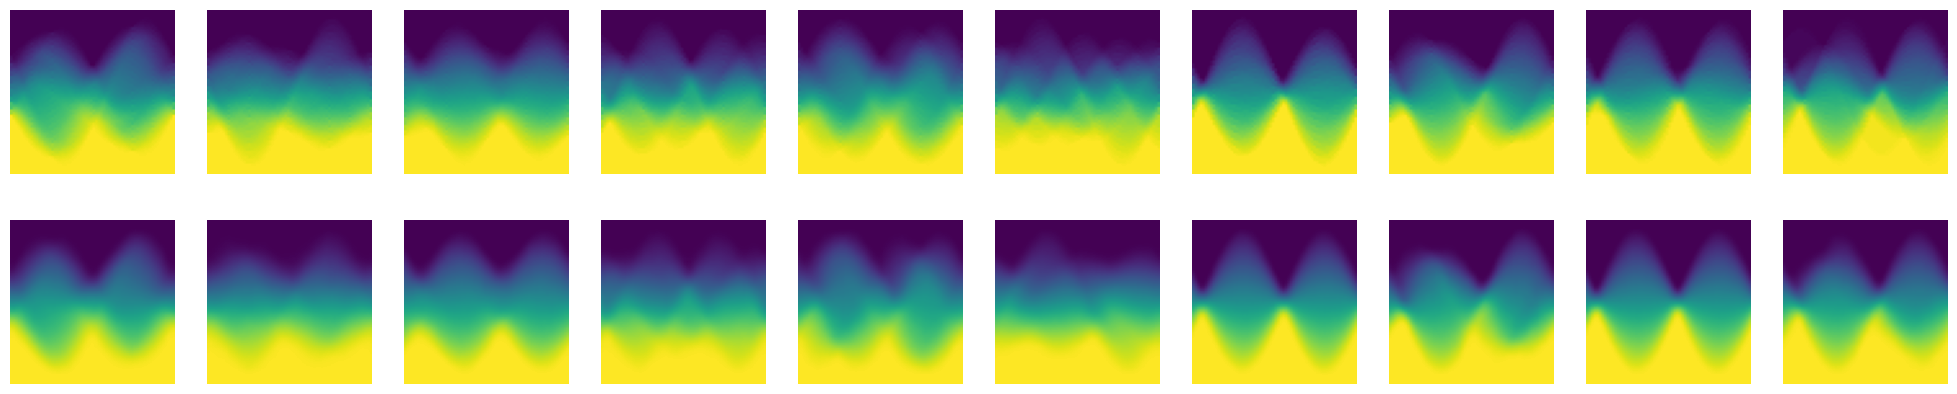

In [13]:
n_images = 10

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(25,5)
)

for orig_img, recon_img,ax in zip(ect,decoded,axes.T):
    ax[0].imshow(orig_img.cpu().detach().squeeze().numpy())
    ax[0].axis("off")
    ax[1].imshow(recon_img.cpu().detach().squeeze().numpy())
    ax[1].axis("off")

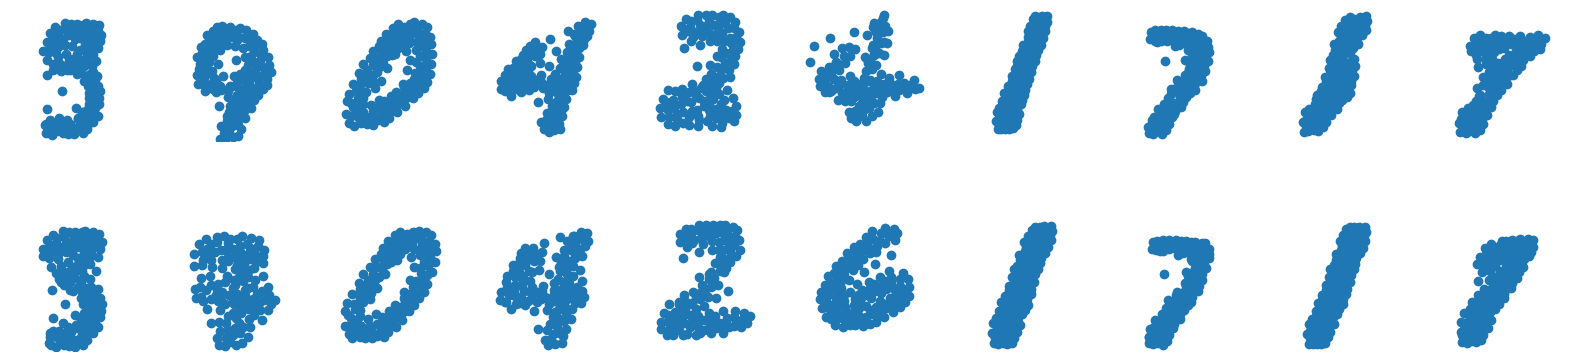

In [14]:
# Pass reconstruction through the point cloud decoder

import numpy as np

def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)



with torch.no_grad():
    recon_vae_batch = ect_encoder_litmodel.model.forward(decoded)
    recon_batch = ect_encoder_litmodel.model.forward(ect)


n_images = 10

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20,5)
)


for recon_pts, recon_vae_pts,ax in zip(recon_batch,recon_vae_batch,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
    recon_vae_pts = recon_vae_pts.view(-1,2).cpu().detach().squeeze().numpy()
    recon_pts = rotate(recon_pts, degrees=-90)
    recon_vae_pts = rotate(recon_vae_pts, degrees=-90)


    ax[0].scatter(recon_pts[:,0],recon_pts[:,1])
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([-1,1])
    ax[0].set_aspect(1)
    ax[0].axis("off")
    ax[1].scatter(recon_vae_pts[:,0],recon_vae_pts[:,1])
    ax[1].set_xlim([-1,1])
    ax[1].set_ylim([-1,1])
    ax[1].set_aspect(1)
    ax[1].axis("off")
    

## Sample from VAE and reconstruct points 

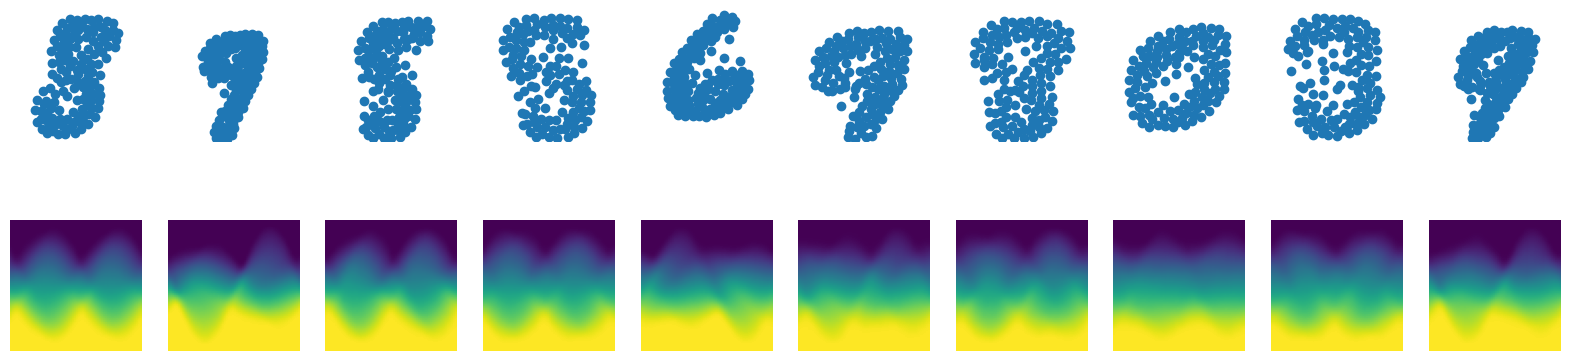

In [15]:
samples = vae_litmodel.model.sample(64, "cuda:0")
samples = (samples + 1) / 2
recon_samples = ect_encoder_litmodel.model.forward(samples)


n_images = 10

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, figsize=(20,5)
)


for samples_pts,sample,ax in zip(recon_samples,samples,axes.T):
    samples_pts = samples_pts.view(-1,2).cpu().detach().squeeze().numpy()
    samples_pts = rotate(samples_pts, degrees=-90)
    ax[0].scatter(samples_pts[:,0],samples_pts[:,1])
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([-1,1])
    ax[0].set_aspect(1)
    ax[0].axis("off")
    ax[1].imshow(sample.squeeze().cpu().detach().numpy())
    ax[1].axis("off")
    